In [1]:
from pathlib import Path
import json

import gtfstk as gt
import pandas as pd
import numpy as np
import shapely.geometry as sg


DATA_DIR = Path('../data')
OUT_DIR = Path('../output')

In [2]:
path = DATA_DIR/'wellington_gtfs_20171016.zip'
feed = gt.read_gtfs(path, dist_units='km')
feed.assess_quality()

,indicator,value
0,num_route_short_names_duplicated,0
1,frac_route_short_names_duplicated,0
2,num_stop_time_dists_missing,340007
3,frac_stop_time_dists_missing,1
4,num_direction_ids_missing,0
5,frac_direction_ids_missing,0
6,num_trips_missing_shapes,0
7,frac_trips_missing_shapes,0
8,num_departure_times_missing,0
9,frac_departure_times_missing,0


In [3]:
# shapes_g = feed.shapes_to_geojson()
# path = Path('../wellington_shapes_20171016.geojson')
# with path.open('w') as tgt:
#     json.dump(shapes_g, tgt)

In [4]:
"""
If no shapes, use stops only.
If shapes, then add distances to stop times and to shapes
"""
trip_stats = feed.compute_trip_stats(compute_dist_from_shapes=True)
feed = feed.append_dist_to_stop_times(trip_stats)


In [5]:
def refine(xs, n):
    """
    Given a strictly increasing NumPy array ``xs`` of at least two numbers
    x_1 < x_2 < ... < x_r and a nonnegative integer ``n``, 
    insert into the list ``n`` more numbers between x_1 and x_r
    in a spread-out way.
    Return the resulting list as a NumPy array.
    """
    while n > 0:
        diffs = np.diff(xs)

        # Get indices i, j of biggest diffs d_i > d_j.
        # Use the method at https://stackoverflow.com/a/23734295 for speed.
        try:
            indices = np.argpartition(diffs, -2)[-2:]
            i, j = indices[np.argsort(diffs[indices])[::-1]]
            d_i, d_j = diffs[i], diffs[j]
            
            # Choose k => 1 least such that d_i/(k + 1) < d_j
            # with the intent of inserting k evenly spaced points 
            # between x_i and x_{i+1}
            k = int(max(1, np.ceil(d_i/d_j - 1)))

            # Shrink k if necessary so as not to exceed number of remaining points
            k = min(k, n)
        except ValueError:
            # Here xs has only two elements, hence diffs has only one element.
            # Using try-except because faster than if-else.
            i = 0
            d_i = diffs[0]
            k = n
        
        # Insert the k points, updating xs
        xs = np.concatenate([
          xs[:i + 1], 
          [xs[i] + s*d_i/(k + 1) for s in range(1, k + 1)], 
          xs[i + 1:]
          ])
        
        # Update n
        n -= k
        
    return xs

In [6]:
# Test refine() some

xs = np.array([0, 3/4, 1])
assert np.array_equal(refine(xs, 0), xs)
assert np.array_equal(refine(xs, 1), np.array([0, 3/8, 3/4, 1]))
assert np.array_equal(refine(xs, 2), np.array([0, 1/4, 1/2, 3/4, 1]))
assert np.array_equal(refine(xs, 3), np.array([0, 1/4, 1/2, 3/4, 7/8, 1]))

In [57]:
def get_stop_patterns(feed, trip_ids=None, sep='-'):
    """
    Return the DataFrame ``feed.trips`` with the additional column
    
    - ``'stop_pattern'``: string; the stop IDs along the 
      trip joined by the separator ``sep``
      
    If a list of trip IDs is also given, then restrict the output
    to those trip IDs.
    """
    st = feed.stop_times.sort_values(['trip_id', 'stop_sequence'])
    if trip_ids is not None:
        # Filter to given trip IDs
        st = st[st['trip_id'].isin(trip_ids)].copy()
            
    def get_pattern(group):
        return group.stop_id.str.cat(sep=sep)
        
    f = st.groupby('trip_id').apply(get_pattern).reset_index().rename(
      columns={0: 'stop_pattern'})
    return feed.trips.merge(f)


In [99]:
def build_sample_points_by_trip(feed, trip_ids=None, n=100):
    """
    Given a GTFS feed (GTFSTK Feed instance), 
    preferably with a ``feed.stop_times.shape_dist_traveled`` column, 
    return a dictionary of the form 
    
    trip ID -> list of n (longitude, latitude) sample points along trip.
    
    Regarding the list of sample points, suppose a trip has k stops.
    If k < n, the trip has a shape, and all the ``shape_dist_traveled``
    values of the trip's stop times are present, then the sample points 
    comprise the k stops of the trip along with ``n - k`` additional points
    somewhat evenly sampled from the trip's shape, all in the order of the trip's travel.
    Else if k > n, then the sample points include only n stops: no points (n=0); 
    the first stop (n=1); the first and the last stop (n=2);
    the first, last, and n - k random stops (n > 2).
    Else, the sample points are the k stops.
    
    NOTES:
    
    - In the case of choosing random stops, the choices will be the same
      for across all runs of this function (by using a fixed 
      random number generator seed), which is good for debugging.
    """
    # Seed random number generator for reproducible results
    np.random.seed(42)
    
    if trip_ids is None:
        # Use all trip IDs
        trip_ids = feed.trips.trip_id
    
    # Get stops times
    st = feed.stop_times
    st = st[st['trip_id'].isin(trip_ids)].sort_values(
      ['trip_id', 'stop_sequence'])
    
    # Join in stop patterns
    t = get_stop_patterns(feed, trip_ids)
    st = st.merge(t[['trip_id', 'shape_id', 'stop_pattern']])
    
    # Join in stop locations
    st = st.merge(feed.stops[['stop_id', 'stop_lon', 'stop_lat']])

    # Create shape_dist_traveled column if it does not exist
    if not 'shape_dist_traveled' in st:
        st['shape_dist_traveled'] = np.nan
    
    # Get shape geometries
    geom_by_shape = feed.build_geometry_by_shape(shape_ids=t.shape_id) or {}

    # First build dictionary (shape ID, stop pattern) -> list of (lon, lat) sample points,
    # instead of trip ID -> list of (lon, lat) sample points, because the former
    # avoids repeating computations
    points_by_ssp = {}    
    for trip_id, group in st.groupby('trip_id'):
        shape_id, stop_pattern = group[['shape_id', 'stop_pattern']].iloc[0]
        if (shape_id, stop_pattern) in points_by_ssp:
            # Already computed
            continue
            
        k = group.shape[0]  # Number of stops along trip
        if k < n and (shape_id in geom_by_shape)\
          and group['shape_dist_traveled'].notnull().all():
            # Start with stop points, and mark their distances for later sorting.
            # Scale distances to interval [0, 1] to avoid changing coordinate systems.            
            group['shape_dist_traveled'] /= group['shape_dist_traveled'].max()
            stop_points = group[['stop_lon', 'stop_lat', 'shape_dist_traveled']].values
            dists = group['shape_dist_traveled'].values
            
            # Get n - k nicely spaced points from trip shape.
            new_dists = np.setdiff1d(refine(dists, n - k), dists)                 
            geom = geom_by_shape[shape_id]
            shape_points = [
              list(geom.interpolate(d, normalized=True).coords[0]) + [d]
              for d in new_dists]
            
            # Combine with stop points and sort
            points = sorted(np.concatenate([stop_points, shape_points]).tolist(), 
              key=lambda x: x[2])
            
            # Remove distance markers
            points = [x[:2] for x in points]

        elif k > n:
            # Use n stop points only
            if n == 0:
                points = []
            elif n == 1:
                # First stop
                points = group[['stop_lon', 'stop_lat']].iloc[0].values.tolist() 
            elif n == 2:
                # First and last stop
                ix = [0, k - 1]
                points = group[['stop_lon', 'stop_lat']].iloc[ix].values.tolist() 
            else:
                # First, last, and n - 2 random stops
                ix = np.concatenate([[0, k - 1], 
                  np.random.choice(range(1, k - 1), n - 2, replace=False)])
                ix = sorted(ix)
                points = group[['stop_lon', 'stop_lat']].iloc[ix].values.tolist()
        else:
            # Best can do is use the stop points
            points = group[['stop_lon', 'stop_lat']].values.tolist()

        points_by_ssp[(shape_id, stop_pattern)] = points

    # Build final dict trip ID -> list of (lon, lat) sample points
    return {t: points_by_ssp[(s, sp)] 
      for t, s, sp in t[['trip_id', 'shape_id', 'stop_pattern']].values}


In [100]:
t = feed.trips.sample(frac=0.01)
%time tp1 = build_sample_points_by_trip(feed, t.trip_id, 4)
%time tp2 = build_sample_points_by_trip(feed, t.trip_id, 50)


CPU times: user 296 ms, sys: 0 ns, total: 296 ms
Wall time: 295 ms


/home/araichev/.virtualenvs/snap_bus_routes/lib/python3.5/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 3.11 s, sys: 4 ms, total: 3.11 s
Wall time: 3.11 s


81__1__3342__VLYF__506__506


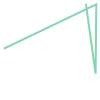

In [103]:
tid = t.trip_id.iat[1]
print(tid)
l1 = sg.LineString(tp1[tid])
l2 = sg.LineString(tp2[tid])
l1

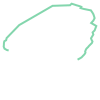

In [104]:
l2